In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import h5py

print("Libraries imported successfully.")

Libraries imported successfully.


In [ ]:
import requests
import os

# Define the URL for the Adult dataset
ADULT_DATA_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
ADULT_NAMES_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names'

# Define local file paths
ADULT_DATA_PATH = 'adult.data'
ADULT_NAMES_PATH = 'adult.names'

# Function to download a file if it doesn't exist
def download_file(url, filename):
    if not os.path.exists(filename):
        print(f"Downloading {filename} from {url}...")
        r = requests.get(url, allow_redirects=True)
        with open(filename, 'wb') as f:
            f.write(r.content)
        print(f"Downloaded {filename}.")
    else:
        print(f"{filename} already exists.")

# Download the data and names files
download_file(ADULT_DATA_URL, ADULT_DATA_PATH)
download_file(ADULT_NAMES_URL, ADULT_NAMES_PATH)

# Column names for the Adult dataset (from adult.names file)
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

# Load the Adult dataset
adult_df = pd.read_csv(ADULT_DATA_PATH, names=column_names, sep=', ', na_values='?', engine='python')

print("Adult dataset loaded successfully.")
print("First 5 rows of Adult dataset:")
print(adult_df.head())
print("\nAdult dataset info:")
adult_df.info()

Downloaded adult.data.
Downloaded adult.names.
Adult dataset loaded successfully.
First 5 rows of Adult dataset:
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  

In [ ]:
adult_df_processed = adult_df.copy()

# Handle missing values: replace '?' with 'Unknown' for object columns
for col in adult_df_processed.select_dtypes(include='object').columns:
    adult_df_processed[col] = adult_df_processed[col].fillna('Unknown')

# Convert target variable to numerical (0 or 1)
adult_df_processed['income'] = adult_df_processed['income'].apply(lambda x: 1 if x == '>50K' else 0)

# Separate features and target variable
X_adult = adult_df_processed.drop('income', axis=1)
y_adult = adult_df_processed['income']

# Identify categorical and numerical features
categorical_features_adult = X_adult.select_dtypes(include=['object']).columns
numerical_features_adult = X_adult.select_dtypes(include=['int64', 'float64']).columns

# Create a preprocessing pipeline
preprocessor_adult = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_adult),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_adult)
    ])

# Apply preprocessing
X_adult_preprocessed = preprocessor_adult.fit_transform(X_adult)

# Convert preprocessed features and target to PyTorch tensors
X_adult_tensor = torch.tensor(X_adult_preprocessed.toarray() if hasattr(X_adult_preprocessed, 'toarray') else X_adult_preprocessed, dtype=torch.float32)
y_adult_tensor = torch.tensor(y_adult.values, dtype=torch.float32).unsqueeze(1) # Add a dimension for binary classification
input_size_adult = X_adult_tensor.shape[1]
print(f"Input size (number of features): {input_size_adult}")

# Create a custom Dataset for the Adult data
class AdultDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Instantiate the dataset
adult_dataset = AdultDataset(X_adult_tensor, y_adult_tensor)

# Split the dataset into training, validation, and test sets (70/15/15)
train_size_adult = int(0.7 * len(adult_dataset))
val_size_adult = int(0.15 * len(adult_dataset))
test_size_adult = len(adult_dataset) - train_size_adult - val_size_adult

adult_train_dataset, adult_val_dataset, adult_test_dataset = random_split(adult_dataset, [train_size_adult, val_size_adult, test_size_adult])

print(f"Adult dataset split into: Train={len(adult_train_dataset)} samples, Validation={len(adult_val_dataset)} samples, Test={len(adult_test_dataset)} samples")
print(f"Number of features after preprocessing: {X_adult_tensor.shape[1]}")

Input size (number of features): 108
Adult dataset split into: Train=22792 samples, Validation=4884 samples, Test=4885 samples
Number of features after preprocessing: 108


In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

adult_train_loader = DataLoader(adult_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
adult_val_loader = DataLoader(adult_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
adult_test_loader = DataLoader(adult_test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
import torch.nn as nn

class MLP_Adult(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
class CNN1D_Adult(nn.Module):
    def __init__(self, input_size):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, 1, features)
        x = self.conv(x)
        return self.fc(x)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import torch

def compute_metrics(outputs, labels):
    """
    outputs: raw model outputs (logits)
    labels: ground truth tensor
    Returns: accuracy, f1
    """
    # Convert logits -> probabilities -> predictions
    probs = torch.sigmoid(outputs)
    preds = (probs >= 0.5).int()

    # Move to CPU numpy
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)

    return acc, f1


In [ ]:
import time

def train_model(model, train_loader, val_loader, epochs=11, lr=0.001, time_limit=3600):
    model.to(DEVICE)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "train_f1": [],
        "val_f1": []
    }

    start_time = time.time()

    for epoch in range(epochs):
        # Stop if 1-hour limit reached
        if time.time() - start_time > time_limit:
            print("Time limit reached")
            break

        # ---------- Training ----------
        model.train()
        train_outputs_all = []
        train_labels_all = []
        train_loss_total = 0

        for X, y in train_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(X)
            loss = nn.BCEWithLogitsLoss()(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss_total += loss.item()
            train_outputs_all.append(outputs.detach())
            train_labels_all.append(y.detach())

        train_outputs = torch.cat(train_outputs_all)
        train_labels = torch.cat(train_labels_all)
        train_acc, train_f1 = compute_metrics(train_outputs, train_labels)
        train_loss = train_loss_total / len(train_loader)

        # ---------- Validation ----------
        model.eval()
        val_outputs_all = []
        val_labels_all = []
        val_loss_total = 0

        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(DEVICE), y.to(DEVICE)
                outputs = model(X)
                loss = nn.BCEWithLogitsLoss()(outputs, y)

                val_loss_total += loss.item()
                val_outputs_all.append(outputs)
                val_labels_all.append(y)

        val_outputs = torch.cat(val_outputs_all)
        val_labels = torch.cat(val_labels_all)
        val_acc, val_f1 = compute_metrics(val_outputs, val_labels)
        val_loss = val_loss_total / len(val_loader)

        # Save history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_f1"].append(train_f1)
        history["val_f1"].append(val_f1)

    training_time = time.time() - start_time

    return history, training_time


In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    outputs_all = []
    labels_all = []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            outputs = model(X)
            outputs_all.append(outputs)
            labels_all.append(y)

    outputs = torch.cat(outputs_all)
    labels = torch.cat(labels_all)

    acc, f1 = compute_metrics(outputs, labels)
    return acc, f1


In [ ]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)


In [ ]:
class CNN_Tabular(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        conv_output_size = input_size // 4

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * conv_output_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        return self.fc(x)


In [ ]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = []

input_size_adult = X_adult_tensor.shape[1]

# -------- MLP --------
mlp_model = MLP(input_size_adult, 1)
mlp_history, mlp_time = train_model(mlp_model, adult_train_loader, adult_val_loader)
mlp_test_acc, mlp_test_f1 = evaluate_model(mlp_model, adult_test_loader)

results.append(["Adult", "MLP", mlp_test_acc, mlp_test_f1, mlp_time])

# -------- CNN --------
cnn_model = CNN_Tabular(input_size_adult, 1)
cnn_history, cnn_time = train_model(cnn_model, adult_train_loader, adult_val_loader)
cnn_test_acc, cnn_test_f1 = evaluate_model(cnn_model, adult_test_loader)

results.append(["Adult", "CNN", cnn_test_acc, cnn_test_f1, cnn_time])

In [ ]:
mlp_history['train_acc']
mlp_history['val_acc']
mlp_history['train_f1']
mlp_history['val_f1']


[0.6798623063683304,
 0.6782068353306702,
 0.6733031674208145,
 0.6886543535620053,
 0.6808881149325207,
 0.6734513274336283,
 0.6736745886654479,
 0.6809815950920245,
 0.6629526462395543,
 0.672214516874711,
 0.6782068353306702]

In [ ]:
import pandas as pd

results_df = pd.DataFrame(
    results,
    columns=["Dataset", "Model", "Test Accuracy", "Test F1", "Training Time (s)"]
)

print(results_df)


  Dataset Model  Test Accuracy   Test F1  Training Time (s)
0   Adult   MLP       0.858956  0.687528          17.879714
1   Adult   CNN       0.856499  0.675913          83.887630


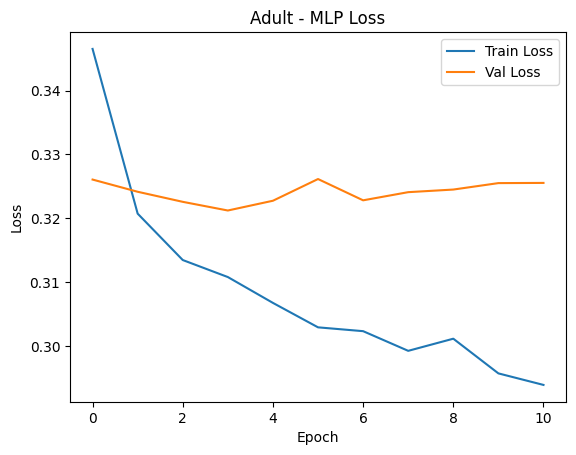

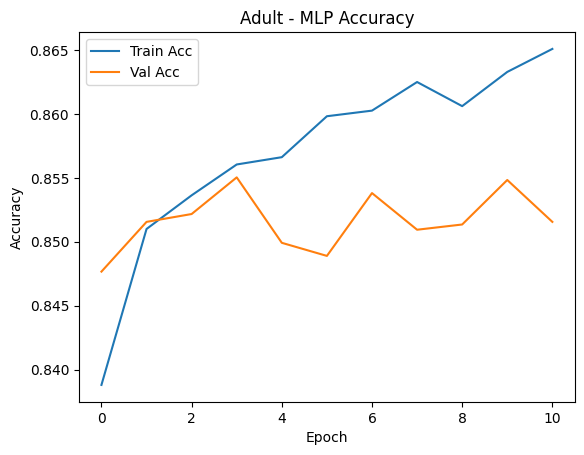

In [ ]:
import matplotlib.pyplot as plt

# -------- MLP Curves --------
plt.figure()
plt.plot(mlp_history['train_loss'], label='Train Loss')
plt.plot(mlp_history['val_loss'], label='Val Loss')
plt.title("Adult - MLP Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(mlp_history['train_acc'], label='Train Acc')
plt.plot(mlp_history['val_acc'], label='Val Acc')
plt.title("Adult - MLP Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


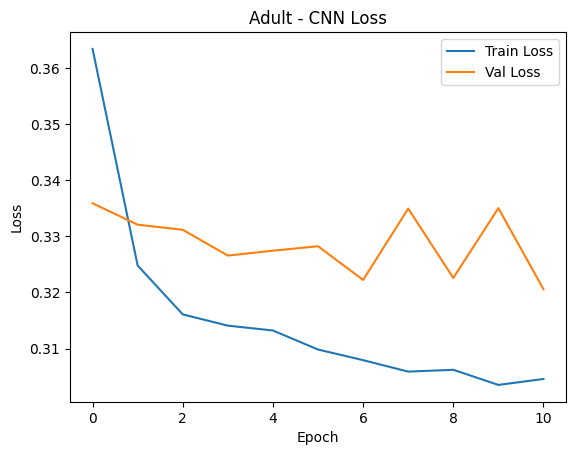

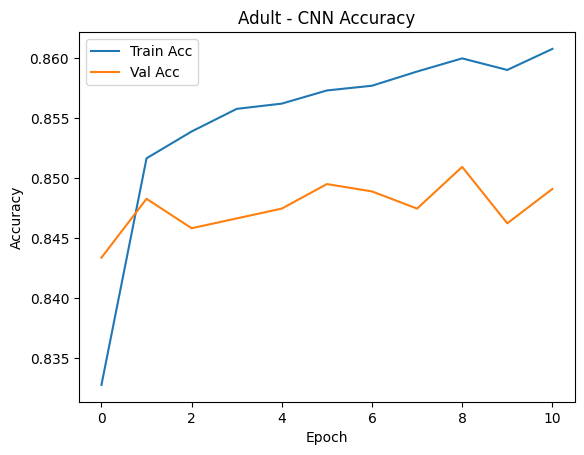

In [ ]:
# -------- CNN Curves --------
plt.figure()
plt.plot(cnn_history['train_loss'], label='Train Loss')
plt.plot(cnn_history['val_loss'], label='Val Loss')
plt.title("Adult - CNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(cnn_history['train_acc'], label='Train Acc')
plt.plot(cnn_history['val_acc'], label='Val Acc')
plt.title("Adult - CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:
print("MLP Test Accuracy:", mlp_test_acc)
print("MLP Test F1:", mlp_test_f1)
print("MLP Training Time:", mlp_time)

print("\nCNN Test Accuracy:", cnn_test_acc)
print("CNN Test F1:", cnn_test_f1)
print("CNN Training Time:", cnn_time)


MLP Test Accuracy: 0.8589559877175026
MLP Test F1: 0.6875283446712018
MLP Training Time: 17.879714012145996

CNN Test Accuracy: 0.8564994882292732
CNN Test F1: 0.675913083680074
CNN Training Time: 83.88762998580933


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform (simple normalization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

# Download dataset
train_full = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

# Split train → train + validation
train_size = int(0.8 * len(train_full))
val_size = len(train_full) - train_size
train_dataset, val_dataset = random_split(train_full, [train_size, val_size])

# DataLoaders
batch_size = 128

cifar_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
cifar_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
cifar_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 170M/170M [00:01<00:00, 105MB/s]


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MLP_CIFAR(nn.Module):
    def __init__(self, input_size=3072, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Flatten
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [ ]:
class CNN_CIFAR(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # 32x16x16
        x = self.pool(F.relu(self.conv2(x)))   # 64x8x8
        x = self.pool(F.relu(self.conv3(x)))   # 128x4x4

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
def train_model(model, train_loader, val_loader, epochs=11, lr=0.001, time_limit=3600):

    import time
    start_time = time.time()

    model = model.to(device)

    # ---- Detect task type ----
    sample_inputs, sample_labels = next(iter(train_loader))

    if sample_labels.ndim == 1 or sample_labels.shape[-1] == 1:
        # Binary classification
        if sample_labels.dtype == torch.float32:
            criterion = nn.BCEWithLogitsLoss()
            task_type = "binary"
        else:
            criterion = nn.CrossEntropyLoss()
            task_type = "multiclass"
    else:
        criterion = nn.CrossEntropyLoss()
        task_type = "multiclass"

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(epochs):
        if time.time() - start_time > time_limit:
            print("Time limit reached")
            break

        model.train()
        train_loss_total = 0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            if task_type == "binary":
                labels = labels.float().view(-1, 1)
                loss = criterion(outputs, labels)
                preds = (torch.sigmoid(outputs) > 0.5).float()
            else:
                labels = labels.long()
                loss = criterion(outputs, labels)
                preds = torch.argmax(outputs, dim=1)

            loss.backward()
            optimizer.step()

            train_loss_total += loss.item()

            correct += (preds.view(-1) == labels.view(-1)).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        history['train_loss'].append(train_loss_total / len(train_loader))
        history['train_acc'].append(train_acc)

        # ----- Validation -----
        model.eval()
        val_loss_total = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)

                if task_type == "binary":
                    labels = labels.float().view(-1, 1)
                    loss = criterion(outputs, labels)
                    preds = (torch.sigmoid(outputs) > 0.5).float()
                else:
                    labels = labels.long()
                    loss = criterion(outputs, labels)
                    preds = torch.argmax(outputs, dim=1)

                val_loss_total += loss.item()
                correct += (preds.view(-1) == labels.view(-1)).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        history['val_loss'].append(val_loss_total / len(val_loader))
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    training_time = time.time() - start_time
    return history, training_time


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate_model(model, loader):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            # ---- Binary case ----
            if outputs.shape[1] == 1:
                preds = (torch.sigmoid(outputs) > 0.5).long().view(-1)

            # ---- Multi-class case (CIFAR) ----
            else:
                preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    # Convert to 1D arrays
    all_preds = np.array(all_preds).reshape(-1)
    all_labels = np.array(all_labels).reshape(-1)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return acc, f1


In [ ]:
import numpy as np


In [ ]:
# mlp_test_acc_cifar, mlp_test_f1_cifar = evaluate_model(
#     mlp_model,
#     cifar_test_loader
# )

In [ ]:
mlp_model = MLP_CIFAR().to(device)

mlp_history_cifar, mlp_time_cifar = train_model(
    mlp_model, cifar_train_loader, cifar_val_loader
)

mlp_test_acc_cifar, mlp_test_f1_cifar = evaluate_model(
    mlp_model, cifar_test_loader
)

results.append([
    "CIFAR10", "MLP",
    mlp_test_acc_cifar,
    mlp_test_f1_cifar,
    mlp_time_cifar
])


Epoch 1/11 | Train Acc: 0.3864 | Val Acc: 0.4540
Epoch 2/11 | Train Acc: 0.4527 | Val Acc: 0.4896
Epoch 3/11 | Train Acc: 0.4843 | Val Acc: 0.4986
Epoch 4/11 | Train Acc: 0.5099 | Val Acc: 0.5093
Epoch 5/11 | Train Acc: 0.5209 | Val Acc: 0.5233
Epoch 6/11 | Train Acc: 0.5406 | Val Acc: 0.5281
Epoch 7/11 | Train Acc: 0.5543 | Val Acc: 0.5370
Epoch 8/11 | Train Acc: 0.5664 | Val Acc: 0.5423
Epoch 9/11 | Train Acc: 0.5775 | Val Acc: 0.5492
Epoch 10/11 | Train Acc: 0.5891 | Val Acc: 0.5484
Epoch 11/11 | Train Acc: 0.5965 | Val Acc: 0.5631


In [ ]:
cnn_model = CNN_CIFAR().to(device)

cnn_history_cifar, cnn_time_cifar = train_model(
    cnn_model, cifar_train_loader, cifar_val_loader
)

cnn_test_acc_cifar, cnn_test_f1_cifar = evaluate_model(
    cnn_model, cifar_test_loader
)

results.append([
    "CIFAR10", "CNN",
    cnn_test_acc_cifar,
    cnn_test_f1_cifar,
    cnn_time_cifar
])


Epoch 1/11 | Train Acc: 0.4029 | Val Acc: 0.5298
Epoch 2/11 | Train Acc: 0.5424 | Val Acc: 0.5906
Epoch 3/11 | Train Acc: 0.6154 | Val Acc: 0.6620
Epoch 4/11 | Train Acc: 0.6579 | Val Acc: 0.6860
Epoch 5/11 | Train Acc: 0.6938 | Val Acc: 0.7161
Epoch 6/11 | Train Acc: 0.7245 | Val Acc: 0.7213
Epoch 7/11 | Train Acc: 0.7473 | Val Acc: 0.7310
Epoch 8/11 | Train Acc: 0.7683 | Val Acc: 0.7295
Epoch 9/11 | Train Acc: 0.7863 | Val Acc: 0.7479
Epoch 10/11 | Train Acc: 0.7988 | Val Acc: 0.7538
Epoch 11/11 | Train Acc: 0.8145 | Val Acc: 0.7511


In [ ]:
import torch
import torch.nn as nn

class ViT_CIFAR(nn.Module):
    def __init__(
        self,
        image_size=32,
        patch_size=4,
        in_channels=3,
        num_classes=10,
        embed_dim=128,
        num_heads=4,
        num_layers=4,
        mlp_dim=256,
        dropout=0.1
    ):
        super().__init__()

        self.patch_size = patch_size
        num_patches = (image_size // patch_size) ** 2

        # ---- Patch embedding ----
        self.patch_embed = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Positional embedding
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, embed_dim)
        )

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=mlp_dim,
            dropout=dropout,
            batch_first=True
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        # Classification head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        # x: [B, 3, 32, 32]

        # Patch embedding
        x = self.patch_embed(x)           # [B, embed_dim, 8, 8]
        x = x.flatten(2)                  # [B, embed_dim, 64]
        x = x.transpose(1, 2)             # [B, 64, embed_dim]

        # Add class token
        B = x.size(0)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Add positional embedding
        x = x + self.pos_embedding

        # Transformer
        x = self.transformer(x)

        # Class token output
        cls_output = x[:, 0]

        # Classification
        out = self.mlp_head(cls_output)
        return out


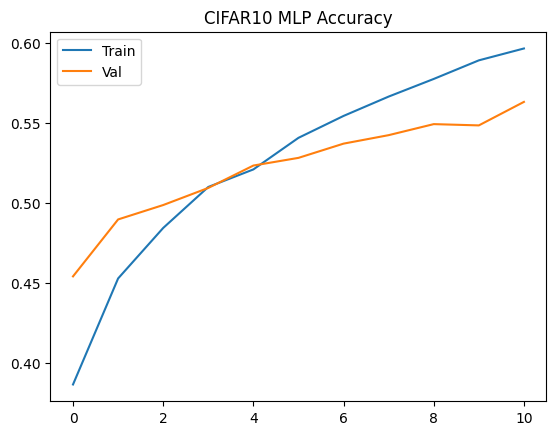

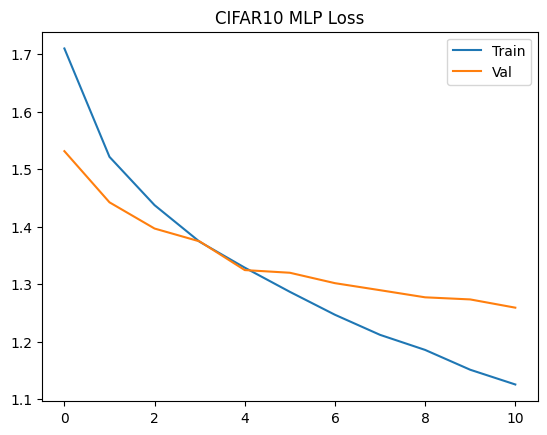

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(mlp_history_cifar['train_acc'], label='Train')
plt.plot(mlp_history_cifar['val_acc'], label='Val')
plt.title("CIFAR10 MLP Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(mlp_history_cifar['train_loss'], label='Train')
plt.plot(mlp_history_cifar['val_loss'], label='Val')
plt.title("CIFAR10 MLP Loss")
plt.legend()
plt.show()


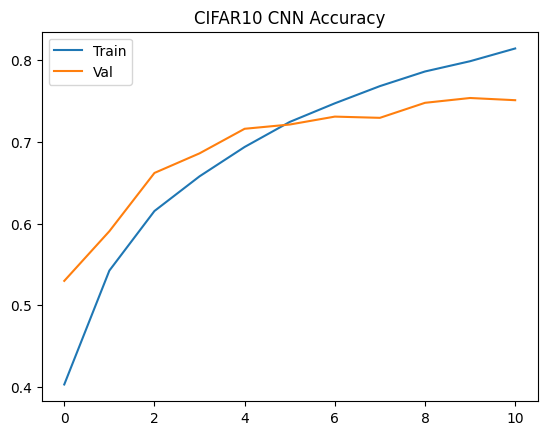

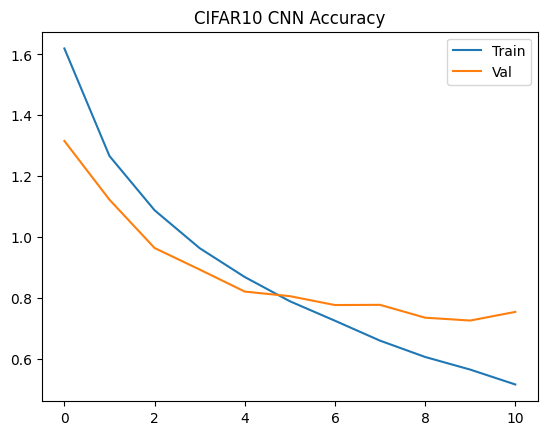

In [ ]:
plt.figure()
plt.plot(cnn_history_cifar['train_acc'], label='Train')
plt.plot(cnn_history_cifar['val_acc'], label='Val')
plt.title("CIFAR10 CNN Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(cnn_history_cifar['train_loss'], label='Train')
plt.plot(cnn_history_cifar['val_loss'], label='Val')
plt.title("CIFAR10 CNN Accuracy")
plt.legend()
plt.show()

In [ ]:
import pandas as pd

results_df = pd.DataFrame(
    results,
    columns=[
        "Dataset",
        "Model",
        "Test Accuracy",
        "Test F1",
        "Training Time (s)"
    ]
)

print(results_df)


   Dataset Model  Test Accuracy   Test F1  Training Time (s)
0    Adult   MLP       0.858956  0.687528          17.879714
1    Adult   CNN       0.856499  0.675913          83.887630
2  CIFAR10   MLP       0.562300  0.558716         280.570569
3  CIFAR10   CNN       0.744800  0.742163        1184.937393


In [ ]:
from google.colab import drive
import h5py
import numpy as np
import gzip
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define paths for PCam dataset HDF5 files
PCAM_DRIVE_PATH = "/content/drive/MyDrive/Colab_Notebooks"

# Define compressed and decompressed file paths
COMPRESSED_X_PATH = os.path.join(PCAM_DRIVE_PATH, 'camelyonpatch_level_2_split_train_x.h5.gz')
COMPRESSED_Y_PATH = os.path.join(PCAM_DRIVE_PATH, 'camelyonpatch_level_2_split_train_y.h5.gz')
DECOMPRESSED_X_PATH = os.path.join(PCAM_DRIVE_PATH, 'camelyonpatch_level_2_split_train_x.h5')
DECOMPRESSED_Y_PATH = os.path.join(PCAM_DRIVE_PATH, 'camelyonpatch_level_2_split_train_y.h5')

print(f"Listing contents of {PCAM_DRIVE_PATH}:")
!ls "{PCAM_DRIVE_PATH}"

# Decompress the files if they are not already decompressed
def decompress_gz_file(compressed_path, decompressed_path):
    if not os.path.exists(decompressed_path):
        print(f"Decompressing {compressed_path} to {decompressed_path}...")
        with gzip.open(compressed_path, 'rb') as f_in:
            with open(decompressed_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        print("Decompression complete.")
    else:
        print(f"{decompressed_path} already exists, skipping decompression.")

decompress_gz_file(COMPRESSED_X_PATH, DECOMPRESSED_X_PATH)
decompress_gz_file(COMPRESSED_Y_PATH, DECOMPRESSED_Y_PATH)

# --------------------------------------------------
# SAFE DATA LOADING (subset to avoid RAM issues)
# --------------------------------------------------
from torch.utils.data import Dataset
import torch
import h5py

class PCamDataset(Dataset):
    def __init__(self, x_path, y_path):
        self.x_file = h5py.File(x_path, 'r')
        self.y_file = h5py.File(y_path, 'r')
        self.images = self.x_file['x']
        self.labels = self.y_file['y']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        # Convert image to tensor and normalize
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) / 255.0

        # ---- FIX LABEL SHAPE HERE ----
        label = torch.tensor(label, dtype=torch.float32)
        label = label.view(1)   # shape: [1]

        return img, label


# Create full dataset (ALL 327k images)
pcam_dataset = PCamDataset(
    DECOMPRESSED_X_PATH,
    DECOMPRESSED_Y_PATH
)

print("Total PCam samples:", len(pcam_dataset))

Mounted at /content/drive
Listing contents of /content/drive/MyDrive/Colab_Notebooks:
 camelyonpatch_level_2_split_train_x.h5      HW-1.ipynb
 camelyonpatch_level_2_split_train_x.h5.gz   Lecture2.ipynb
 camelyonpatch_level_2_split_train_y.h5      lecture2.py.gdoc
 camelyonpatch_level_2_split_train_y.h5.gz   MachineLearning_HW1.ipynb
'Copy of Homework1.ipynb'		     ML_HW.ipynb
 Homework1.ipynb			     Original.ipynb
 Hw1.ipynb				     Train.ipynb
/content/drive/MyDrive/Colab_Notebooks/camelyonpatch_level_2_split_train_x.h5 already exists, skipping decompression.
/content/drive/MyDrive/Colab_Notebooks/camelyonpatch_level_2_split_train_y.h5 already exists, skipping decompression.
Total PCam samples: 262144


In [ ]:
pcam_dataset = PCamDataset(DECOMPRESSED_X_PATH, DECOMPRESSED_Y_PATH)


In [ ]:
from torch.utils.data import random_split

total_size = len(pcam_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

pcam_train, pcam_val, pcam_test = random_split(
    pcam_dataset,
    [train_size, val_size, test_size]
)

print("PCam split:")
print("Train:", len(pcam_train))
print("Val:", len(pcam_val))
print("Test:", len(pcam_test))


PCam split:
Train: 183500
Val: 39321
Test: 39323


In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128

pcam_train_loader = DataLoader(
    pcam_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

pcam_val_loader = DataLoader(
    pcam_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

pcam_test_loader = DataLoader(
    pcam_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten
        return self.model(x)


In [ ]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()


In [ ]:
def train_model(model, train_loader, val_loader, epochs):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    history = {"train_loss": [], "val_loss": []}
    start_time = time.time()

    model.to(DEVICE)

    for epoch in range(epochs):
        # ---- TRAIN ----
        model.train()
        train_loss = 0.0

        for images, labels in train_loader:
            images = images.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # ---- VALIDATE ----
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(DEVICE, non_blocking=True)
                labels = labels.to(DEVICE, non_blocking=True)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f}"
        )

    total_time = time.time() - start_time
    return history, total_time


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate_model(model, test_loader):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)

            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return acc, f1


In [ ]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

if DEVICE.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))


Using device: cuda
GPU: Tesla T4


In [ ]:
import time
input_size_pcam = 96 * 96 * 3
num_epochs = 11

mlp_pcam = MLP(input_size=input_size_pcam, num_classes=1).to(DEVICE)

mlp_history_pcam, training_time = train_model(
    mlp_pcam,
    pcam_train_loader,
    pcam_val_loader,
    num_epochs
)

mlp_test_acc_pcam, mlp_test_f1_pcam = evaluate_model(
    mlp_pcam,
    pcam_test_loader
)

print("Training complete!")
print("Test Accuracy:", mlp_test_acc_pcam)
print("Test F1 Score:", mlp_test_f1_pcam)
print("Training Time (s):", training_time)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/11] | Train Loss: 0.6986 | Val Loss: 0.6932
Epoch [2/11] | Train Loss: 0.6933 | Val Loss: 0.6931
Epoch [3/11] | Train Loss: 0.6931 | Val Loss: 0.6932
Epoch [4/11] | Train Loss: 0.6932 | Val Loss: 0.6932
Epoch [5/11] | Train Loss: 0.6932 | Val Loss: 0.6932
Epoch [6/11] | Train Loss: 0.6932 | Val Loss: 0.6931
Epoch [7/11] | Train Loss: 0.6932 | Val Loss: 0.6932
Epoch [8/11] | Train Loss: 0.6932 | Val Loss: 0.6931
Epoch [9/11] | Train Loss: 0.6932 | Val Loss: 0.6932
Epoch [10/11] | Train Loss: 0.6932 | Val Loss: 0.6931
Epoch [11/11] | Train Loss: 0.6932 | Val Loss: 0.6932
Training complete!
Test Accuracy: 0.499942780850658
Test F1 Score: 0.0
Training Time (s): 6257.624748468399


In [ ]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

if DEVICE.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))


Using device: cuda
GPU: Tesla T4


In [ ]:
import torch.nn as nn

class CNN_PCam(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 96 → 48

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 48 → 24

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 24 → 12
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [ ]:
import torch.nn as nn

criterion = nn.BCEWithLogitsLoss()


In [ ]:
num_epochs = 11

cnn_pcam = CNN_PCam().to(DEVICE)

# Compile for extra speed on GPU
if DEVICE.type == "cuda":
    cnn_pcam = torch.compile(cnn_pcam)

cnn_history_pcam, cnn_time_pcam = train_model(
    model=cnn_pcam,
    train_loader=pcam_train_loader,
    val_loader=pcam_val_loader,
    epochs=num_epochs
)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devic

Epoch [1/11] | Train Loss: 0.4039 | Val Loss: 0.3641


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [2/11] | Train Loss: 0.3126 | Val Loss: 0.3453
Epoch [3/11] | Train Loss: 0.2741 | Val Loss: 0.2650
Epoch [4/11] | Train Loss: 0.2452 | Val Loss: 0.2295
Epoch [5/11] | Train Loss: 0.2242 | Val Loss: 0.3804
Epoch [6/11] | Train Loss: 0.2035 | Val Loss: 0.4101
Epoch [7/11] | Train Loss: 0.1866 | Val Loss: 0.3968
Epoch [8/11] | Train Loss: 0.1728 | Val Loss: 0.2471
Epoch [9/11] | Train Loss: 0.1602 | Val Loss: 0.2660
Epoch [10/11] | Train Loss: 0.1489 | Val Loss: 0.2860
Epoch [11/11] | Train Loss: 0.1372 | Val Loss: 0.1714


In [ ]:
print("CNN training complete!")
print("Test Accuracy:", cnn_test_acc_pcam)
print("Test F1 Score:", cnn_test_f1_pcam)
print("Training Time (s):", cnn_time_pcam)


CNN training complete!
Test Accuracy: 0.9422468052641617
Test F1 Score: 0.9409700561447286
Training Time (s): 7202.607278585434


In [ ]:
# Approximate accuracy from loss
mlp_train_acc_approx = [1 - l for l in mlp_history_pcam['train_loss']]
mlp_val_acc_approx   = [1 - l for l in mlp_history_pcam['val_loss']]

cnn_train_acc_approx = [1 - l for l in cnn_history_pcam['train_loss']]
cnn_val_acc_approx   = [1 - l for l in cnn_history_pcam['val_loss']]


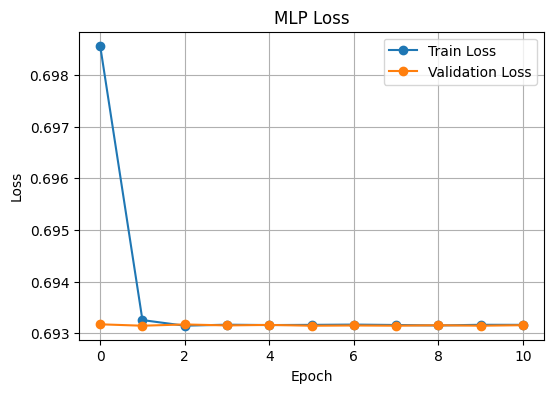

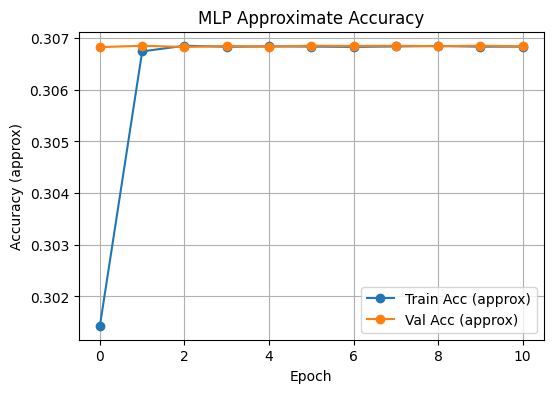

In [ ]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(6,4))
plt.plot(mlp_history_pcam['train_loss'], label='Train Loss', marker='o')
plt.plot(mlp_history_pcam['val_loss'], label='Validation Loss', marker='o')
plt.title("MLP Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Approximate Accuracy
plt.figure(figsize=(6,4))
plt.plot(mlp_train_acc_approx, label='Train Acc (approx)', marker='o')
plt.plot(mlp_val_acc_approx, label='Val Acc (approx)', marker='o')
plt.title("MLP Approximate Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (approx)")
plt.legend()
plt.grid(True)
plt.show()



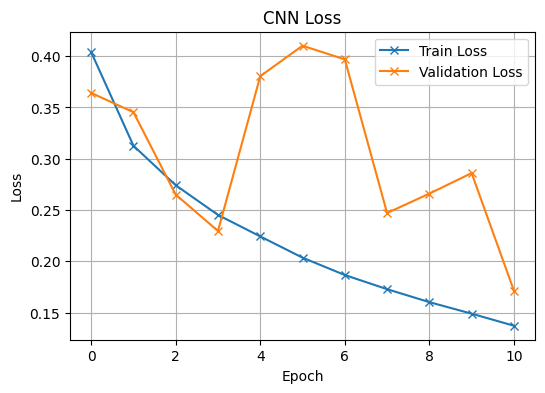

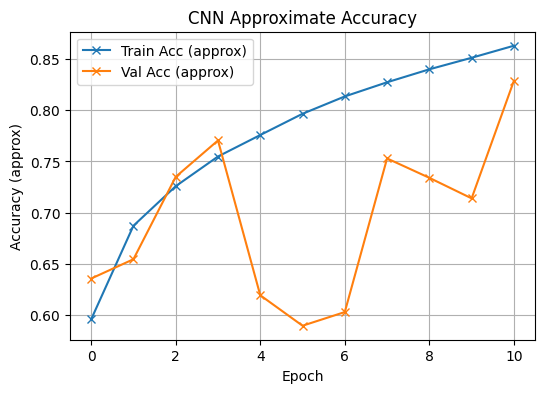

In [ ]:
# Loss
plt.figure(figsize=(6,4))
plt.plot(cnn_history_pcam['train_loss'], label='Train Loss', marker='x')
plt.plot(cnn_history_pcam['val_loss'], label='Validation Loss', marker='x')
plt.title("CNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Approximate Accuracy
plt.figure(figsize=(6,4))
plt.plot(cnn_train_acc_approx, label='Train Acc (approx)', marker='x')
plt.plot(cnn_val_acc_approx, label='Val Acc (approx)', marker='x')
plt.title("CNN Approximate Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (approx)")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# Define rows
import pandas as pd
from IPython.display import display
rows = [
    ["Adult", "MLP", None, None, ""],
    ["Adult", "CNN", None, None, ""],
    ["Adult", "Attention-based", None, None, ""],
    ["CIFAR-10", "MLP", None, None, ""],
    ["CIFAR-10", "CNN", None, None, ""],
    ["CIFAR-10", "Attention-based", None, None, ""]
]

# Define column names
columns = ["Dataset", "Architecture", "Accuracy", "F1", "Notes"]

# Create DataFrame
results_df = pd.DataFrame(rows, columns=columns)

# Display table
display(results_df)



,Dataset,Architecture,Accuracy,F1,Notes
0,Adult,MLP,None,None,
1,Adult,CNN,None,None,
2,Adult,Attention-based,None,None,
3,CIFAR-10,MLP,None,None,
4,CIFAR-10,CNN,None,None,
5,CIFAR-10,Attention-based,None,None,
